In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Task 1

One algorithm that implements multi-instance learning is the Multi-Instance Boosting (MIBoost) algorithm. 

MIBoost is a boosting-based approach that can handle multi-instance data, where each instance is represented as a bag of instances (i.e., a set of instances) instead of a single instance.

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.ensemble import GradientBoostingClassifier

I will use the "Musk" dataset

Data Set Information:

This dataset describes a set of 102 molecules of which 39 are judged by human experts to be musks and the remaining 63 molecules are judged to be non-musks. The goal is to learn to predict whether new molecules will be musks or non-musks. However, the 166 features that describe these molecules depend upon the exact shape, or conformation, of the molecule. Because bonds can rotate, a single molecule can adopt many different shapes. To generate this data set, all the low-energy conformations of the molecules were generated to produce 6,598 conformations. Then, a feature vector was extracted that describes each conformation.

This many-to-one relationship between feature vectors and molecules is called the "multiple instance problem". When learning a classifier for this data, the classifier should classify a molecule as "musk" if ANY of its conformations is classified as a musk. A molecule should be classified as "non-musk" if NONE of its conformations is classified as a musk.

In [ ]:
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/musk/clean2.data.Z

In [ ]:
!uncompress clean2.data.Z 

gzip: clean2.data already exists; do you wish to overwrite (y or n)? y


In [ ]:
# Load the Musk dataset
data = pd.read_csv("./clean2.data")

In [ ]:
# Split the dataset into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.3)

In [ ]:
# Extract the features and labels from the training data
train_features = train_data.iloc[:, 3:-1]
train_labels = train_data.iloc[:, -1]

In [ ]:
# Define the possible values for the parameters to be tuned
param_grid = {'learning_rate': [0.01, 0.001], 'n_estimators': [200, 300, 400]}

# Create a GridSearchCV object with the MIBoost model
model = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=5, n_jobs=-1,
                     verbose=1, scoring='accuracy')

In [ ]:
model.fit(train_features, train_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.001],
                         'n_estimators': [200, 300, 400]},
             scoring='accuracy', verbose=1)

In [ ]:
# Extract the features and labels from the testing data
test_features = test_data.iloc[:, 3:-1]
test_labels = test_data.iloc[:, -1]

In [ ]:
# Evaluate the MIBoost model on the testing data
score = model.score(test_features, test_labels)
print("Accuracy:", round(score, 3))

pred_labels = model.predict(test_features)
score = f1_score(pred_labels, test_labels)
print("F1:", round(score, 3))

Accuracy: 0.938
F1: 0.766


In [ ]:
# Print the best parameters found by the grid search
print("Best parameters:", model.best_params_)

Best parameters: {'learning_rate': 0.01, 'n_estimators': 400}


# Task 2

In [1]:
!pip install -q pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done


In [4]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from tqdm import tqdm

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Counting c_v coherence for different number of topics
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of text
    limit : Maximum number of topics

    model_list : List of LDA models
    coherence_values :Coherence corresponding to the LDA model with the number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = gensim.models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
stoplist = stopwords.words("english")

In [8]:
# Load the dataset (for example, the 20 Newsgroups dataset)
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = data.data

In [9]:
# Preprocessing the data (tokenization, stopword removal, stemming, etc.)
texts = [[word for word in document.lower().split()
         if word not in stoplist]
         for document in documents]

In [10]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(texts)

In [11]:
# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
corpus = [dictionary.doc2bow(text) for text in texts]

In [12]:
# Training the LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=20,
                                    id2word = dictionary, passes=20)

In [13]:
# Visualizing the topics using pyLDAvis
vis = gensimvis.prepare(ldamodel, corpus, dictionary)

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [14]:
pyLDAvis.enable_notebook()

In [15]:
pyLDAvis.display(vis)

In [16]:
pyLDAvis.save_html(vis, 'use_lda.html')

In [24]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus,
                                                        texts=texts,
                                                        start=10, limit=20, step=2)

100%|██████████| 5/5 [02:55<00:00, 35.02s/it]


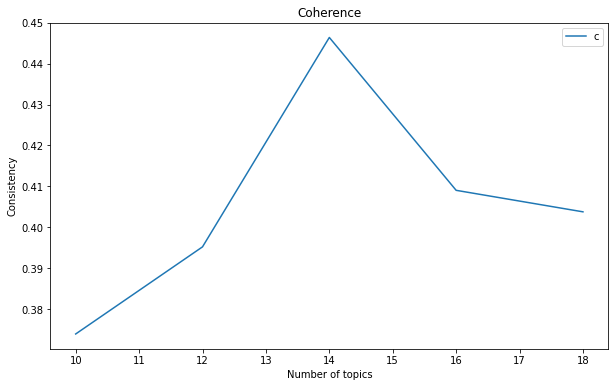

In [27]:
import matplotlib.pyplot as plt
from matplotlib import figure

limit=20; start=10; step=2;
x = range(start, limit, step)

plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values)

plt.title("Coherence")
plt.xlabel("Number of topics")
plt.ylabel("Consistency")

plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
coherence_values

[0.3739314405851676,
 0.3952239628102469,
 0.4463973893161758,
 0.409039803586148,
 0.40378351304517013]

For our model best num of topics is 14.

# Task 3

Algorithm for semi-supervised learning is the Self-training algorithm. 

Self-training is a simple approach to semi-supervised learning, where a small labeled dataset is used to train a classifier, which is then applied to the unlabeled dataset to predict labels for additional samples. 

The predicted labels are then added to the labeled dataset, and the process is repeated until all samples have labels.

In [ ]:
import numpy as np

from sklearn.metrics import confusion_matrix

from tensorflow import  keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

import seaborn as sns
import matplotlib.pyplot as plt

I will use Mnist dataset

In [ ]:
# Load the labeled dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Reshape data, because we have only black/white data
x_train = x_train.reshape(-1, 784) / 255.0
x_test = x_test.reshape(-1, 784) / 255.0

In [ ]:
# Split the labeled dataset into a training set and a validation set
val_split = 0.1
val_index = int(x_train.shape[0] * (1 - val_split))

x_val = x_train[val_index:]
y_val = y_train[val_index:]

x_train = x_train[:val_index]
y_train = y_train[:val_index]

In [ ]:
# Load the unlabeled dataset
x_unlabeled = np.concatenate((x_test, x_val), axis=0)

In [ ]:
# Define the classifier model
model = Sequential([
    Dense(128, input_shape=(784,), activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax'),
])

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               100480    
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 10)                650       
                                                                 
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


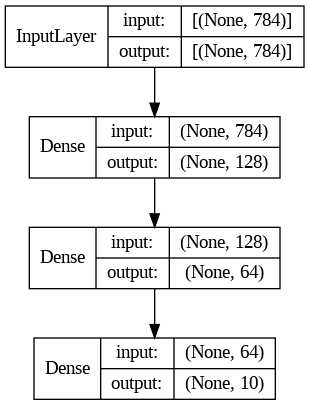

In [ ]:
# Show structure of the model
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
# Train the model on the labeled dataset
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val))

Epoch 1/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2580 - accuracy: 0.9250 - val_loss: 0.1167 - val_accuracy: 0.9657
Epoch 2/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1092 - accuracy: 0.9670 - val_loss: 0.0906 - val_accuracy: 0.9727
Epoch 3/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0759 - accuracy: 0.9762 - val_loss: 0.1001 - val_accuracy: 0.9700
Epoch 4/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0563 - accuracy: 0.9817 - val_loss: 0.0878 - val_accuracy: 0.9733
Epoch 5/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0440 - accuracy: 0.9853 - val_loss: 0.0837 - val_accuracy: 0.9780


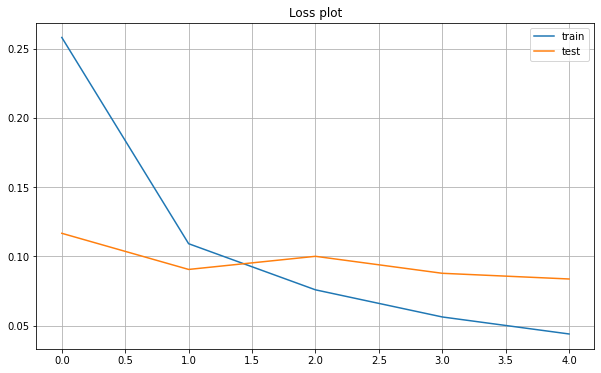

In [ ]:
# Show loss
fig = plt.figure(figsize=(10,6))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.grid()
plt.title('Loss plot')
plt.show()

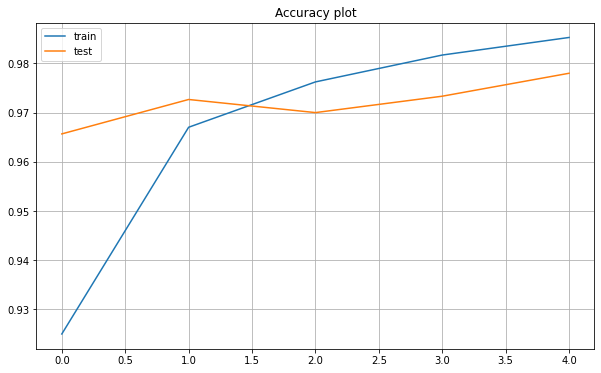

In [ ]:
# Show Accuracy
fig = plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.grid()
plt.title('Accuracy plot')
plt.show()

In [ ]:
# Use the trained model to predict labels for the unlabeled dataset
y_unlabeled = model.predict(x_unlabeled).argmax(axis=1)

500/500 [==============================] - 1s 1ms/step


In [ ]:
# Combine the predicted labels with the original labeled dataset
x_train = np.concatenate((x_train, x_unlabeled), axis=0)
y_train = np.concatenate((y_train, y_unlabeled), axis=0)

In [ ]:
# Set a threshold for the proportion of predicted labels
threshold = 0.95

In [ ]:
# Repeat the process until the threshold is reached
while np.mean(y_unlabeled != -1) < threshold:
  # Train the model on the updated labeled dataset
  model.fit(x_train, y_train, batch_size=32, epochs=5, validation_data=(x_val, y_val))

  # Use the trained model to predict labels for the unlabeled dataset
  y_unlabeled = model.predict(x_unlabeled).argmax(axis=1)

  # Combine the predicted labels with the original labeled dataset
  x_train = np.concatenate((x_train, x_unlabeled), axis=0)
  y_train = np.concatenate((y_train, y_unlabeled), axis=0)

In [ ]:
y_pred = model.predict(x_val)

188/188 [==============================] - 0s 1ms/step


In [ ]:
conf_matr = confusion_matrix(y_val, [y.argmax() for y in y_pred])

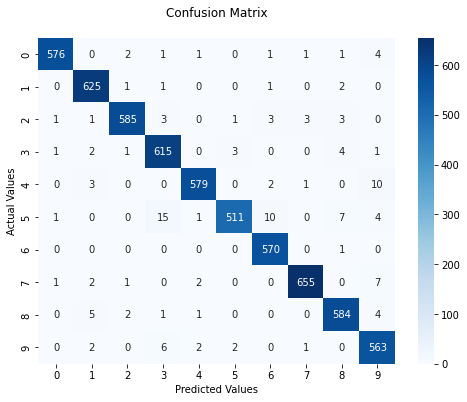

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6)) 

rnd = np.round(conf_matr).astype(int)

sns.heatmap(rnd, annot=rnd.astype(str), fmt='', cmap='Blues')

# Set titles for heatmap
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

## Display the visualization of the Confusion Matrix.
plt.show()